# Autotalker Batch Integration

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 20.01.2023
- **Date of Last Modification:** 27.01.2023

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../autotalker")

In [3]:
import argparse
import os
import pickle
import random
import warnings
from copy import deepcopy
from datetime import datetime

import anndata as ad
import matplotlib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scanpy as sc
import scib
import scipy.sparse as sp
import seaborn as sns
import squidpy as sq
import torch
from matplotlib.pyplot import rc_context
from sklearn.decomposition import KernelPCA

from autotalker.benchmarking import compute_arclisi, compute_cad
from autotalker.models import Autotalker
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_mebocost_es_interactions,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions,
                              filter_and_combine_gp_dict_gps)

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=58, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.209.62.242', 36278), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=58, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.209.62.242', 36288), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=58, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.209.62.242', 36300), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/sbir

### 1.2 Define Parameters

In [4]:
## Dataset
dataset = "seqfish_mouse_organogenesis"
batch1 = "embryo1_z2"
batch2 = "embryo1_z5"
batch3 = "embryo2_z2"
batch4 = "embryo2_z5"
batch5 = "embryo3_z2"
batch6 = "embryo3_z5"
n_neighbors = 4 # 12
reference_removed_cell_type = "Presomitic mesoderm"

## Model
# AnnData Keys
counts_key = "counts"
cell_type_key = "celltype_mapped_refined"
adj_key = "spatial_connectivities"
spatial_key = "spatial"
gp_names_key = "autotalker_gp_names"
active_gp_names_key = "autotalker_active_gp_names"
gp_targets_mask_key = "autotalker_gp_targets"
gp_sources_mask_key = "autotalker_gp_sources"
latent_key = "autotalker_latent"
condition_key = "batch"

# Architecture
active_gp_thresh_ratio = 0.03
gene_expr_recon_dist = "nb"
n_cond_embed = 3

# Trainer
n_epochs = 40
n_epochs_all_gps = 20
lr = 0.001
lambda_edge_recon = 0.001
lambda_gene_expr_recon = 0.00033

# Benchmarking
spatial_knng_key = "autotalker_spatial_knng"
latent_knng_key = "autotalker_latent_knng"

## Others
random_seed = 42
load_timestamp = None

### 1.3 Run Notebook Setup

In [5]:
sc.set_figure_params(figsize=(6, 6))
sns.set_style("whitegrid", {'axes.grid' : False})

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [6]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [7]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Create Directories

In [8]:
# Define paths
figure_folder_path = f"../figures/{dataset}/batch_integration/{current_timestamp}"
model_artifacts_folder_path = f"../artifacts/{dataset}/batch_integration/{current_timestamp}"
gp_data_folder_path = "../datasets/gp_data" # gene program data
srt_data_folder_path = "../datasets/srt_data" # spatially resolved transcriptomics data
srt_data_gold_folder_path = f"{srt_data_folder_path}/gold"
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"

# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(model_artifacts_folder_path, exist_ok=True)

## 2. Data

### 2.1 Load Data

In [9]:
adata_batch1 = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_{batch1}.h5ad")
adata_batch2 = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_{batch2}.h5ad")
adata_batch3 = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_{batch3}.h5ad")
adata_batch4 = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_{batch4}.h5ad")
adata_batch5 = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_{batch5}.h5ad")
adata_batch6 = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_{batch6}.h5ad")

adata_batch_list = [adata_batch1,
                    adata_batch2,
                    adata_batch3,
                    adata_batch4,
                    adata_batch5,
                    adata_batch6]

### 2.2 Artificially Remove Cell Type from Reference (Embryo 1 + 2) for Recovery by Query (Embryo 3)

In [10]:
# Artificially remove cell type from reference for recovery by query
for i in range(4):
    adata_batch_list[i] = adata_batch_list[i][adata_batch_list[i].obs["celltype_mapped_refined"] != reference_removed_cell_type]

### 2.3 Compute Spatial Neighbor Graphs

In [11]:
for i in range(len(adata_batch_list)):
    # Compute (separate) spatial neighborhood
    sq.gr.spatial_neighbors(adata_batch_list[i],
                            coord_type="generic",
                            spatial_key=spatial_key,
                            n_neighs=n_neighbors)
    # Make adjacency matrix symmetric
    adata_batch_list[i].obsp["spatial_connectivities"] = adata_batch_list[i].obsp["spatial_connectivities"].maximum(
        adata_batch_list[i].obsp["spatial_connectivities"].T)

### 2.4 Combine Data for One-Shot Batch Integration

In [12]:
adata_one_shot = ad.concat(adata_batch_list, join="inner")

# Combine spatial neighborhood graphs as disconnected components
connectivities_extension_batch1 = sp.csr_matrix((adata_batch_list[0].shape[0],
                                                 (adata_batch_list[1].shape[0] +
                                                  adata_batch_list[2].shape[0] +
                                                  adata_batch_list[3].shape[0] +
                                                  adata_batch_list[4].shape[0] +
                                                  adata_batch_list[5].shape[0])))
connectivities_extension_batch2_before = sp.csr_matrix((adata_batch_list[1].shape[0],
                                                        adata_batch_list[0].shape[0]))
connectivities_extension_batch2_after = sp.csr_matrix((adata_batch_list[1].shape[0],
                                                       (adata_batch_list[2].shape[0] +
                                                        adata_batch_list[3].shape[0] +
                                                        adata_batch_list[4].shape[0] +
                                                        adata_batch_list[5].shape[0])))
connectivities_extension_batch3_before = sp.csr_matrix((adata_batch_list[2].shape[0],
                                                        (adata_batch_list[0].shape[0] +
                                                         adata_batch_list[1].shape[0])))
connectivities_extension_batch3_after = sp.csr_matrix((adata_batch_list[2].shape[0],
                                                       (adata_batch_list[3].shape[0] +
                                                        adata_batch_list[4].shape[0] +
                                                        adata_batch_list[5].shape[0])))
connectivities_extension_batch4_before = sp.csr_matrix((adata_batch_list[3].shape[0],
                                                        (adata_batch_list[0].shape[0] +
                                                         adata_batch_list[1].shape[0] +
                                                         adata_batch_list[2].shape[0])))
connectivities_extension_batch4_after = sp.csr_matrix((adata_batch_list[3].shape[0],
                                                       (adata_batch_list[4].shape[0] +
                                                        adata_batch_list[5].shape[0])))
connectivities_extension_batch5_before = sp.csr_matrix((adata_batch_list[4].shape[0],
                                                        (adata_batch_list[0].shape[0] +
                                                         adata_batch_list[1].shape[0] +
                                                         adata_batch_list[2].shape[0] +
                                                         adata_batch_list[3].shape[0])))
connectivities_extension_batch5_after = sp.csr_matrix((adata_batch_list[4].shape[0],
                                                       adata_batch_list[5].shape[0]))
connectivities_extension_batch6 = sp.csr_matrix((adata_batch_list[5].shape[0],
                                                 (adata_batch_list[0].shape[0] +
                                                  adata_batch_list[1].shape[0] +
                                                  adata_batch_list[2].shape[0] +
                                                  adata_batch_list[3].shape[0] +
                                                  adata_batch_list[4].shape[0])))

connectivities_batch1 = sp.hstack((adata_batch_list[0].obsp["spatial_connectivities"],
                                   connectivities_extension_batch1))
connectivities_batch2 = sp.hstack((connectivities_extension_batch2_before,
                                   adata_batch_list[1].obsp["spatial_connectivities"],
                                   connectivities_extension_batch2_after))
connectivities_batch3 = sp.hstack((connectivities_extension_batch3_before,
                                   adata_batch_list[2].obsp["spatial_connectivities"],
                                   connectivities_extension_batch3_after))
connectivities_batch4 = sp.hstack((connectivities_extension_batch4_before,
                                   adata_batch_list[3].obsp["spatial_connectivities"],
                                   connectivities_extension_batch4_after))
connectivities_batch5 = sp.hstack((connectivities_extension_batch5_before,
                                   adata_batch_list[4].obsp["spatial_connectivities"],
                                   connectivities_extension_batch5_after))
connectivities_batch6 = sp.hstack((connectivities_extension_batch6,
                                   adata_batch_list[5].obsp["spatial_connectivities"]))

connectivities = sp.vstack((connectivities_batch1,
                            connectivities_batch2,
                            connectivities_batch3,
                            connectivities_batch4,
                            connectivities_batch5,
                            connectivities_batch6))

adata_one_shot.obsp["spatial_connectivities"] = connectivities

### 2.5 Combine Data for Query-to-Reference Mapping

In [13]:
# Reference
adata_reference = ad.concat(adata_batch_list[:-2], join="inner")

# Combine spatial neighborhood graphs as disconnected components
connectivities_extension_batch1 = sp.csr_matrix((adata_batch_list[0].shape[0],
                                                 (adata_batch_list[1].shape[0] +
                                                  adata_batch_list[2].shape[0] +
                                                  adata_batch_list[3].shape[0])))
connectivities_extension_batch2_before = sp.csr_matrix((adata_batch_list[1].shape[0],
                                                        adata_batch_list[0].shape[0]))
connectivities_extension_batch2_after = sp.csr_matrix((adata_batch_list[1].shape[0],
                                                       (adata_batch_list[2].shape[0] +
                                                        adata_batch_list[3].shape[0])))
connectivities_extension_batch3_before = sp.csr_matrix((adata_batch_list[2].shape[0],
                                                        (adata_batch_list[0].shape[0] +
                                                         adata_batch_list[1].shape[0])))
connectivities_extension_batch3_after = sp.csr_matrix((adata_batch_list[2].shape[0],
                                                       (adata_batch_list[3].shape[0])))
connectivities_extension_batch4 = sp.csr_matrix((adata_batch_list[3].shape[0],
                                                 (adata_batch_list[0].shape[0] +
                                                  adata_batch_list[1].shape[0] +
                                                  adata_batch_list[2].shape[0])))

connectivities_batch1 = sp.hstack((adata_batch_list[0].obsp["spatial_connectivities"],
                                   connectivities_extension_batch1))
connectivities_batch2 = sp.hstack((connectivities_extension_batch2_before,
                                   adata_batch_list[1].obsp["spatial_connectivities"],
                                   connectivities_extension_batch2_after))
connectivities_batch3 = sp.hstack((connectivities_extension_batch3_before,
                                   adata_batch_list[2].obsp["spatial_connectivities"],
                                   connectivities_extension_batch3_after))
connectivities_batch4 = sp.hstack((connectivities_extension_batch4,
                                   adata_batch_list[3].obsp["spatial_connectivities"]))

connectivities = sp.vstack((connectivities_batch1,
                            connectivities_batch2,
                            connectivities_batch3,
                            connectivities_batch4))

adata_reference.obsp["spatial_connectivities"] = connectivities

In [14]:
# Query
adata_query = ad.concat(adata_batch_list[-2:], join="inner")

# Combine spatial neighborhood graphs as disconnected components
connectivities_extension_batch5 = sp.csr_matrix((adata_batch_list[4].shape[0],
                                                 (adata_batch_list[5].shape[0])))
connectivities_extension_batch6 = sp.csr_matrix((adata_batch_list[5].shape[0],
                                                 (adata_batch_list[4].shape[0])))

connectivities_batch5 = sp.hstack((adata_batch_list[4].obsp["spatial_connectivities"],
                                   connectivities_extension_batch5))
connectivities_batch6 = sp.hstack((connectivities_extension_batch6,
                                   adata_batch_list[5].obsp["spatial_connectivities"]))

connectivities = sp.vstack((connectivities_batch5,
                            connectivities_batch6))

adata_query.obsp["spatial_connectivities"] = connectivities

In [15]:
adata_reference_query_list = [adata_reference, adata_query]

adata_reference_query = ad.concat(adata_reference_query_list, join="inner")

reference_batches = adata_reference.obs["batch"].unique().tolist()
query_batches = adata_query.obs["batch"].unique().tolist()
adata_reference_query.obs["mapping_entity"] = None
adata_reference_query.obs.loc[adata_reference_query.obs["batch"].isin(reference_batches), "mapping_entity"] = "reference"
adata_reference_query.obs.loc[adata_reference_query.obs["batch"].isin(query_batches), "mapping_entity"] = "query"

# Combine spatial neighborhood graphs as disconnected components
connectivities_extension_adata_reference = sp.csr_matrix((adata_reference.shape[0],
                                                          (adata_query.shape[0])))
connectivities_extension_adata_query = sp.csr_matrix((adata_query.shape[0],
                                                      (adata_reference.shape[0])))

connectivities_adata_reference = sp.hstack((adata_reference.obsp["spatial_connectivities"],
                                           connectivities_extension_adata_reference))
connectivities_adata_query = sp.hstack((connectivities_extension_adata_query,
                                       adata_query.obsp["spatial_connectivities"]))

adata_reference_query.obsp["spatial_connectivities"] = sp.vstack((connectivities_adata_reference,
                                                                  connectivities_adata_query))

## 3. Autotalker Model

### 3.1 Prepare Gene Program Mask

In [16]:
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_ratio=0.01,
    load_from_disk=True,
    save_to_disk=False,
    file_path=nichenet_ligand_target_mx_file_path)

In [17]:
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=True,
    file_path=omnipath_lr_interactions_file_path)

In [18]:
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps/",
    species="mouse",
    genes_uppercase=True)

In [19]:
# Combine gene programs into one dictionary
combined_gp_dict = dict(nichenet_gp_dict)
combined_gp_dict.update(omnipath_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)

In [20]:
# Filter and combine gene programs
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode="subset",
    combine_overlap_gps=True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9,
    verbose=True)

print(f"Number of gene programs before filtering and combining: {len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: {len(combined_new_gp_dict)}.")

Removing GP 'CTF1_ligand_receptor_GP' as it is a subset of GP 'CTF1_ligand_targetgenes_GP'.
Removing GP 'LEP_ligand_receptor_GP' as it is a subset of GP 'LEP_ligand_targetgenes_GP'.
Removing GP 'IL4_ligand_receptor_GP' as it is a subset of GP 'IL4_ligand_targetgenes_GP'.
Removing GP 'IL12A_ligand_receptor_GP' as it is a subset of GP 'IL12A_ligand_targetgenes_GP'.
Removing GP 'IL23A_ligand_receptor_GP' as it is a subset of GP 'IL23A_ligand_targetgenes_GP'.
Removing GP 'CSF2_ligand_receptor_GP' as it is a subset of GP 'CSF2_ligand_targetgenes_GP'.
Removing GP 'IL21_ligand_receptor_GP' as it is a subset of GP 'IL21_ligand_targetgenes_GP'.
Removing GP 'TSLP_ligand_receptor_GP' as it is a subset of GP 'TSLP_ligand_targetgenes_GP'.
Removing GP 'GH2_ligand_receptor_GP' as it is a subset of GP 'GH2_ligand_targetgenes_GP'.
Removing GP 'EGF_ligand_receptor_GP' as it is a subset of GP 'EGF_ligand_targetgenes_GP'.
Removing GP 'IL10_ligand_receptor_GP' as it is a subset of GP 'IL10_ligand_targetgen

In [21]:
for adata in (adata_batch_list + 
              [adata_one_shot, adata_reference, adata_query, adata_reference_query]):

    # Add the gene program dictionary as binary masks to the adata for model training
    add_gps_from_gp_dict_to_adata(
        gp_dict=combined_new_gp_dict,
        adata=adata,
        genes_uppercase=True,
        gp_targets_mask_key="autotalker_gp_targets",
        gp_sources_mask_key="autotalker_gp_sources",
        gp_names_key="autotalker_gp_names",
        min_genes_per_gp=1,
        min_source_genes_per_gp=0,
        min_target_genes_per_gp=0,
        max_genes_per_gp=None,
        max_source_genes_per_gp=None,
        max_target_genes_per_gp=None,
        filter_genes_not_in_masks=False)

# Determine dimensionality of hidden encoder
n_hidden_encoder = len(adata_one_shot.uns["autotalker_gp_names"])

# Summarize gene programs
print(f"Number of gene programs with probed genes: {len(adata_one_shot.uns['autotalker_gp_names'])}.")
print(f"Example gene programs: {random.sample(list(adata_one_shot.uns['autotalker_gp_names']), 5)}.")
print(f"Number of gene program target genes: {adata_one_shot.varm['autotalker_gp_targets'].sum()}.")
print(f"Number of gene program source genes: {adata_one_shot.varm['autotalker_gp_sources'].sum()}.")

Number of gene programs with probed genes: 489.
Example gene programs: ['FGF3_ligand_receptor_GP', 'NTN1_ligand_receptor_GP', 'TNFSF14_ligand_targetgenes_GP', 'SCGB3A1_ligand_targetgenes_GP', 'CALCA_ligand_targetgenes_GP'].
Number of gene program target genes: 7476.
Number of gene program source genes: 127.


### 3.2 Unintegrated Baseline

In [ ]:
for batch, adata_batch in zip([f"batch{i+1}" for i in range(6)], adata_batch_list):
    # Initialize model
    model = Autotalker(adata_batch_list[0],
                       counts_key=counts_key,
                       adj_key=adj_key,
                       condition_key=None,
                       gp_names_key=gp_names_key,
                       active_gp_names_key=active_gp_names_key,
                       gp_targets_mask_key=gp_targets_mask_key,
                       gp_sources_mask_key=gp_sources_mask_key,
                       latent_key=latent_key,
                       active_gp_thresh_ratio=active_gp_thresh_ratio,
                       gene_expr_recon_dist=gene_expr_recon_dist,
                       n_hidden_encoder=n_hidden_encoder,
                       n_addon_gps=0,
                       node_label_method="one-hop-attention")

    # Train model
    model.train(n_epochs,
                n_epochs_all_gps=n_epochs_all_gps,
                lr=lr,
                lambda_edge_recon=lambda_edge_recon,
                lambda_gene_expr_recon=lambda_gene_expr_recon,
            verbose=True)

    # Compute metrics
    metrics_dict = {}

    metrics_dict["cad"] = compute_cad(
        adata=model.adata,
        cell_type_key=cell_type_key,
        spatial_knng_key=spatial_knng_key,
        latent_knng_key=latent_knng_key,
        spatial_key=spatial_key,
        latent_key=latent_key,
        n_neighbors=n_neighbors)

    metrics_dict["arclisi"] = compute_arclisi(
        adata=model.adata,
        cell_type_key=cell_type_key,
        spatial_key=spatial_key,
        latent_key=latent_key,
        n_neighbors=n_neighbors)

    """
    metrics_dict["batch_asw"] = scib.me.silhouette_batch(
        adata=model.adata,
        batch_key=condition_key,
        label_key=cell_type_key,
        embed=latent_key)
    """

    print("/n", metrics_dict, "/n")

    # Store to disk
    with open(f"{model_artifacts_folder_path}"
              "/metrics_unintegrated_{batch}.pickle", "wb") as f:
        pickle.dump(metrics_dict, f)

### 3.3 One Shot Batch Integration Without Conditional Embedding

#### 3.3.1 Initialize, Train & Save Model

In [ ]:
# Initialize model
model = Autotalker(adata_one_shot,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   condition_key=None,
                   gp_names_key=gp_names_key,
                   active_gp_names_key=active_gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   active_gp_thresh_ratio=active_gp_thresh_ratio,
                   gene_expr_recon_dist=gene_expr_recon_dist,
                   n_hidden_encoder=n_hidden_encoder,
                   n_addon_gps=0,
                   node_label_method="one-hop-attention")

In [ ]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            verbose=True)

In [ ]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/one_shot_no_cond_embed",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

#### 3.3.2 Load Model

In [ ]:
# Load trained model
if load_timestamp is not None:
    model_artifacts_load_folder_path = f"../artifacts/{dataset}/batch_integration/{load_timestamp}"
else:
    model_artifacts_load_folder_path = model_artifacts_folder_path
    
model = Autotalker.load(dir_path=model_artifacts_load_folder_path + "/one_shot_no_cond_embed",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

#### 3.3.3 Analyze Latent Space

In [ ]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(model.adata, use_rep=latent_key)
sc.tl.umap(model.adata)

In [ ]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(model.adata,
                 color=[condition_key],
                 legend_fontsize=12,
                 return_fig=True)
plt.title("Latent Space Batch Annotations: One-Shot Integration Without Cond Embedding", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_one_shot_no_cond_embed.png",
            bbox_inches="tight")

In [ ]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(model.adata,
                 color=[cell_type_key],
                 return_fig=True)
plt.title("Latent Space Cell Type Annotations: One-Shot Integration Without Cond Embedding", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_one_shot_no_cond_embed.png",
            bbox_inches="tight")

#### 3.3.4 Analyze Batch Correction Metrics

In [ ]:
batch_correction_metrics_one_shot_no_cond_embed = {}

batch_correction_metrics_one_shot_no_cond_embed["silhouette_batch"] = scib.me.silhouette_batch(
    model.adata,
    batch_key=condition_key,
    label_key=cell_type_key,
    embed=latent_key)

print(batch_correction_metrics_one_shot_no_cond_embed)

# Store to disk
with open(f"{model_artifacts_folder_path}"
          "/batch_correction_metrics_one_shot_no_cond_embed.pickle", "wb") as f:
    pickle.dump(batch_correction_metrics_one_shot_no_cond_embed, f)

### 3.4 One-Shot Batch Integration With Conditional Embedding

#### 3.4.1 Initialize, Train & Save Model

In [ ]:
# Initialize model
model = Autotalker(adata_one_shot,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   condition_key=condition_key,
                   cond_embed_injection=["encoder",
                                         "gene_expr_decoder",
                                         "graph_decoder"],
                   n_cond_embed=n_cond_embed,
                   gp_names_key=gp_names_key,
                   active_gp_names_key=active_gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   active_gp_thresh_ratio=active_gp_thresh_ratio,
                   gene_expr_recon_dist=gene_expr_recon_dist,
                   n_hidden_encoder=n_hidden_encoder,
                   n_addon_gps=0,
                   node_label_method="one-hop-attention")

In [ ]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            verbose=True)

In [ ]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/one_shot_cond_embed",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

#### 3.4.2 Load Model

In [ ]:
if load_timestamp is not None:
    model_artifacts_load_folder_path = f"../artifacts/{dataset}/batch_integration/{load_timestamp}"
else:
    model_artifacts_load_folder_path = model_artifacts_folder_path

# Load trained model
model = Autotalker.load(dir_path=model_artifacts_folder_path + "/one_shot_cond_embed",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

#### 3.4.3 Analyze Latent Space

In [ ]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(model.adata, use_rep=latent_key)
sc.tl.umap(model.adata)

In [ ]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(model.adata,
                 color=[condition_key],
                 legend_fontsize=12,
                 return_fig=True)
plt.title("Latent Space Batch Annotations: One-Shot Integration With Cond Embedding", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_one_shot_cond_embed.png",
            bbox_inches="tight")

In [ ]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(model.adata,
                 color=[cell_type_key],
                 return_fig=True)
plt.title("Latent Space Cell Type Annotations: One-Shot Integration With Cond Embedding", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_one_shot_cond_embed.png",
            bbox_inches="tight")

#### 3.4.4 Analyze Metrics

In [ ]:
batch_correction_metrics_one_shot_cond_embed = {}

batch_correction_metrics_one_shot_cond_embed["silhouette_batch"] = scib.me.silhouette_batch(
    model.adata,
    batch_key=condition_key,
    label_key=cell_type_key,
    embed=latent_key)

print(batch_correction_metrics_one_shot_cond_embed)

# Store to disk
with open(f"{model_artifacts_folder_path}"
          "/batch_correction_metrics_one_shot_cond_embed.pickle", "wb") as f:
    pickle.dump(batch_correction_metrics_one_shot_cond_embed, f)

#### 3.4.5 Analyze Conditional Embedding

In [ ]:
# Get conditional embeddings
cond_embed = model.get_conditional_embeddings()
cond = model.adata.obs["batch"].unique()

# Get top 2 principal components and plot them
pca = KernelPCA(n_components=2, kernel="linear")
cond_embed_pca = pca.fit_transform(cond_embed)
sns.scatterplot(x=cond_embed_pca[:, 0], 
                y=cond_embed_pca[:, 1], 
                hue=cond)
plt.title("One-Shot Integration Conditional Embeddings", pad=15)
plt.xlabel("Principal Component 1")
plt.xticks(fontsize=12)
plt.ylabel ("Principal Component 2")
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.02, 0.75),
           loc=2,
           borderaxespad=0.,
           fontsize=12,
           frameon=False)
plt.savefig(f"{figure_folder_path}/one_shot_cond_embed.png",
            bbox_inches="tight")

### 3.5 Query-to-Reference Mapping

#### 3.5.1 Building the Reference

##### 3.5.1.1 Initialize, Train & Save Model

In [23]:
# Initialize model
model = Autotalker(adata_reference,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   condition_key=condition_key,
                   cond_embed_injection=["encoder",
                                         "gene_expr_decoder",
                                         "graph_decoder"],
                   n_cond_embed=n_cond_embed,
                   gp_names_key=gp_names_key,
                   active_gp_names_key=active_gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   active_gp_thresh_ratio=active_gp_thresh_ratio,
                   gene_expr_recon_dist=gene_expr_recon_dist,
                   n_hidden_encoder=n_hidden_encoder,
                   n_addon_gps=0,
                   node_label_method="one-hop-attention")

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> True
CONDITIONAL EMBEDDING INJECTION -> ['encoder', 'gene_expr_decoder', 'graph_decoder']
GRAPH ENCODER -> n_input: 351, n_cond_embed_input: 3, n_hidden: 489, n_latent: 489, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> n_cond_embed_input: 3, n_output: 489, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 489, n_cond_embed_input: 3, n_addon_input: 0, n_output: 702


In [24]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            verbose=True)

--- INITIALIZING TRAINER ---
Number of training nodes: 28379
Number of validation nodes: 3153
Number of training edges: 65815
Number of validation edges: 7312

--- MODEL TRAINING ---
Epoch 1/40 |--------------------| 2.5% val_auroc_score: 0.8961; val_auprc_score: 0.8281; val_best_acc_score: 0.8057; val_best_f1_score: 0.8373; train_kl_reg_loss: 0.0043; train_edge_recon_loss: 0.0076; train_gene_expr_recon_loss: 0.1303; train_group_lasso_reg_loss: 0.0000; train_global_loss: 0.1422; train_optim_loss: 0.1422; val_kl_reg_loss: 0.0040; val_edge_recon_loss: 0.0035; val_gene_expr_recon_loss: 0.1178; val_group_lasso_reg_loss: 0.0000; val_global_loss: 0.1253; val_optim_loss: 0.1253
Epoch 2/40 |█-------------------| 5.0% val_auroc_score: 0.9463; val_auprc_score: 0.9104; val_best_acc_score: 0.8392; val_best_f1_score: 0.8614; train_kl_reg_loss: 0.0034; train_edge_recon_loss: 0.0056; train_gene_expr_recon_loss: 0.1175; train_group_lasso_reg_loss: 0.0000; train_global_loss: 0.1264; train_optim_loss: 0

In [25]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/reference",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

##### 3.5.1.2 Load Model

In [26]:
if load_timestamp is not None:
    model_artifacts_load_folder_path = f"../artifacts/{dataset}/batch_integration/{load_timestamp}"
else:
    model_artifacts_load_folder_path = model_artifacts_folder_path

# Load trained model
model = Autotalker.load(dir_path=model_artifacts_folder_path + "/reference",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> True
CONDITIONAL EMBEDDING INJECTION -> ['encoder', 'gene_expr_decoder', 'graph_decoder']
GRAPH ENCODER -> n_input: 351, n_cond_embed_input: 3, n_hidden: 489, n_latent: 489, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> n_cond_embed_input: 3, n_output: 489, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 489, n_cond_embed_input: 3, n_addon_input: 0, n_output: 702


##### 3.5.1.3 Analyze Latent Space

In [27]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(model.adata, use_rep=latent_key)
sc.tl.umap(model.adata)

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


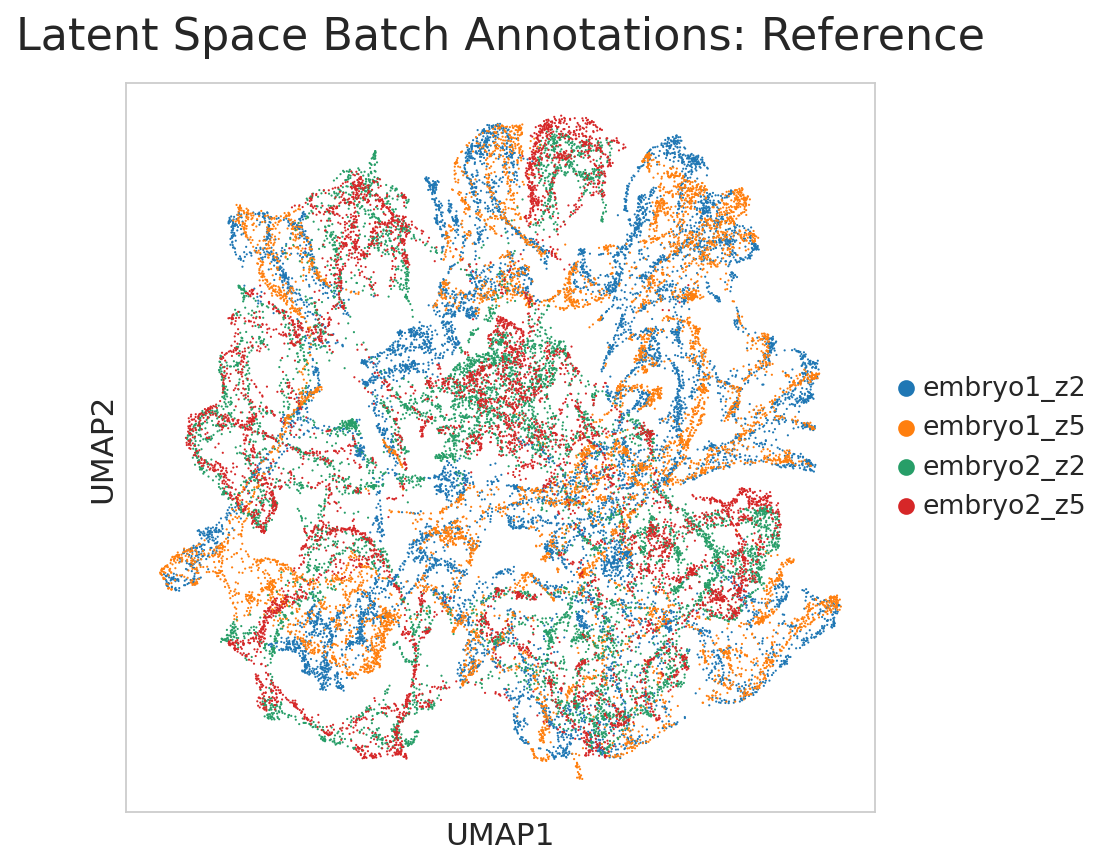

In [28]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(model.adata,
                 color=[condition_key],
                 legend_fontsize=12,
                 return_fig=True)
plt.title("Latent Space Batch Annotations: Reference", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_reference.png",
            bbox_inches="tight")

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


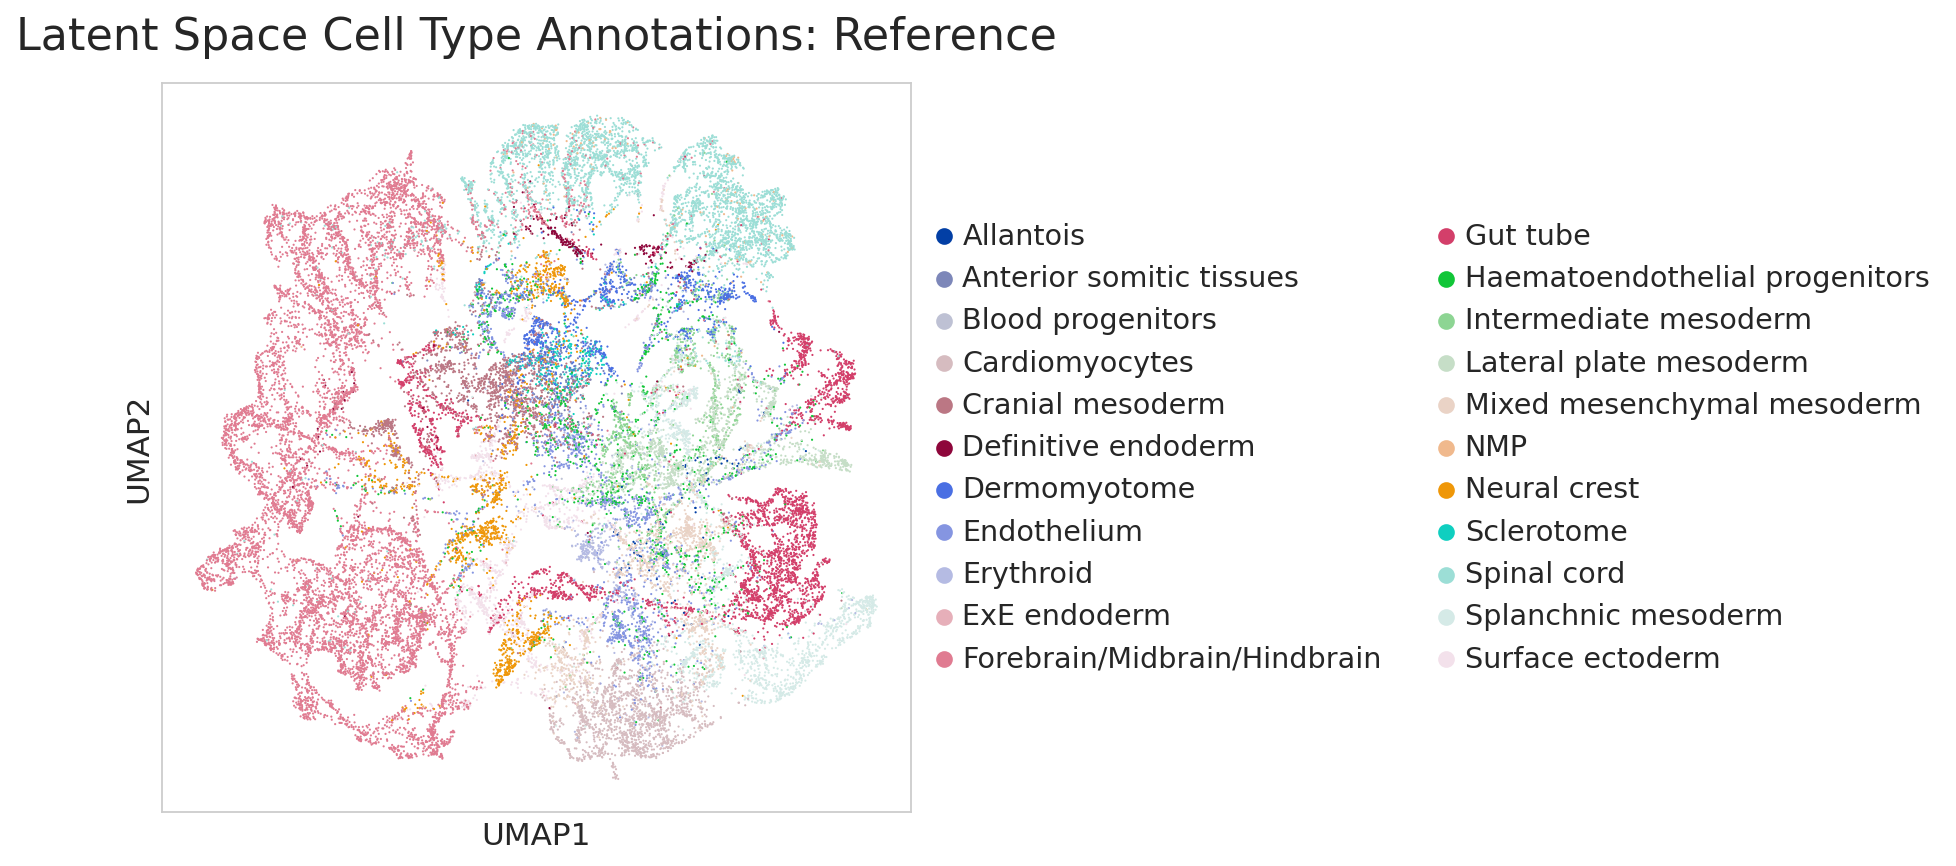

In [29]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(model.adata,
                 color=[cell_type_key],
                 return_fig=True)
plt.title("Latent Space Cell Type Annotations: Reference", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_reference.png",
            bbox_inches="tight")

##### 3.5.1.4 Analyze Metrics

In [30]:
metrics_dict_reference = {}

metrics_dict_reference["cad"] = compute_cad(
    adata=model.adata,
    cell_type_key=cell_type_key,
    spatial_knng_key=spatial_knng_key,
    latent_knng_key=latent_knng_key,
    spatial_key=spatial_key,
    latent_key=latent_key,
    n_neighbors=n_neighbors)

metrics_dict_reference["arclisi"] = compute_arclisi(
    adata=model.adata,
    cell_type_key=cell_type_key,
    spatial_key=spatial_key,
    latent_key=latent_key,
    n_neighbors=n_neighbors)
    
metrics_dict_reference["batch_asw"] = scib.me.silhouette_batch(
    model.adata,
    batch_key=condition_key,
    label_key=cell_type_key,
    embed=latent_key)

print(metrics_dict_reference)

# Store to disk
with open(f"{model_artifacts_folder_path}"
          "/reference_metrics.pickle", "wb") as f:
    pickle.dump(metrics_dict_reference, f)

mean silhouette per group:                                 silhouette_score
group                                           
Allantois                               0.861863
Anterior somitic tissues                0.915098
Blood progenitors                       0.897686
Cardiomyocytes                          0.956426
Cranial mesoderm                        0.932030
Definitive endoderm                     0.928609
Dermomyotome                            0.927385
Endothelium                             0.954273
Erythroid                               0.947806
ExE endoderm                            0.779678
Forebrain/Midbrain/Hindbrain            0.961259
Gut tube                                0.952310
Haematoendothelial progenitors          0.964675
Intermediate mesoderm                   0.926636
Lateral plate mesoderm                  0.975637
Mixed mesenchymal mesoderm              0.932040
NMP                                     0.885404
Neural crest                            0.

##### 3.5.1.5 Analyze Conditional Embedding

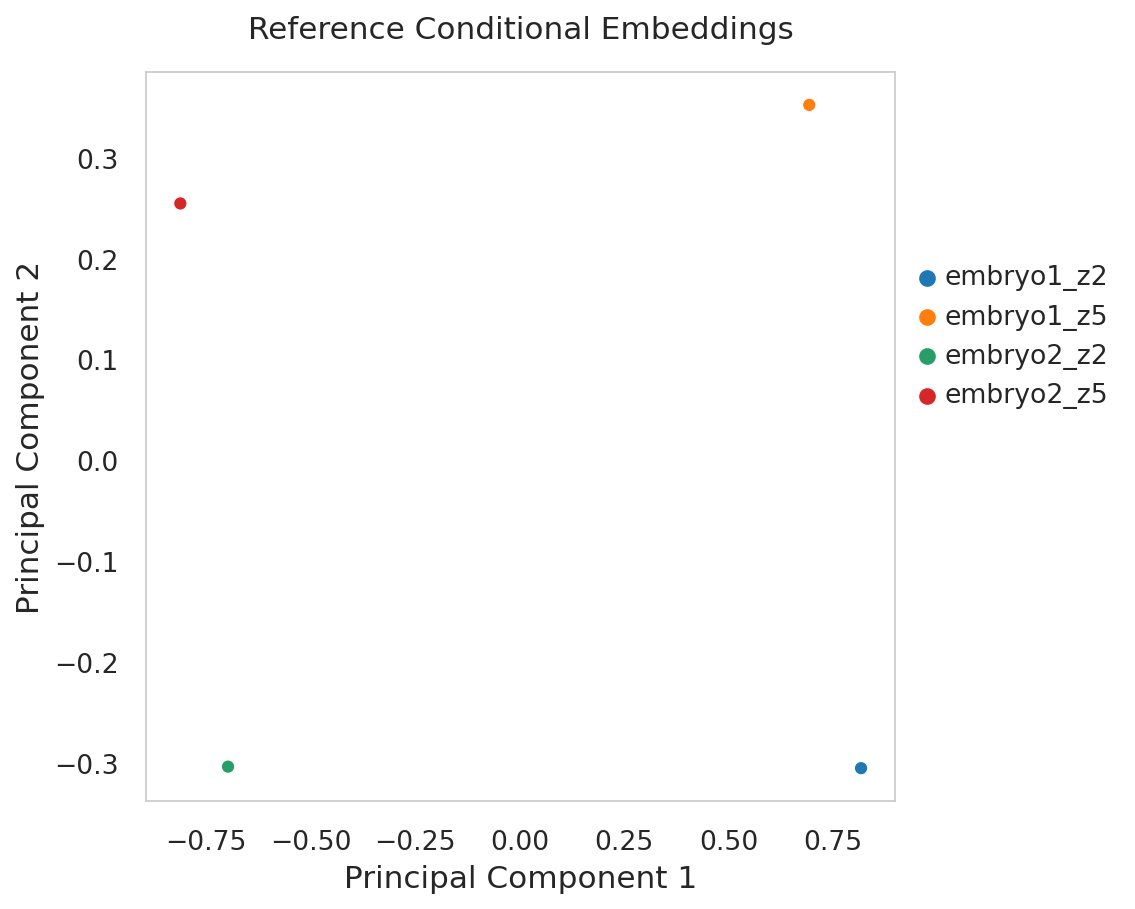

In [31]:
# Get conditional embeddings
cond_embed = model.get_conditional_embeddings()
cond = model.adata.obs["batch"].unique()

# Get top 2 principal components and plot them
pca = KernelPCA(n_components=2, kernel="linear")
cond_embed_pca = pca.fit_transform(cond_embed)
sns.scatterplot(x=cond_embed_pca[:, 0], 
                y=cond_embed_pca[:, 1], 
                hue=cond)
plt.title("Reference Conditional Embeddings", pad=15)
plt.xlabel("Principal Component 1")
plt.xticks(fontsize=12)
plt.ylabel ("Principal Component 2")
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.02, 0.75),
           loc=2,
           borderaxespad=0.,
           fontsize=12,
           frameon=False)
plt.savefig(f"{figure_folder_path}/reference_cond_embed.png",
            bbox_inches="tight")

#### 3.5.2 Mapping the Query

##### 3.5.2.1 Initialize, Train & Save Model

In [32]:
# Load model trained on reference data for transfer learning with query data
# Freeze all weights except for conditional weights
model = Autotalker.load(dir_path=model_artifacts_folder_path + "/reference",
                        adata=adata_query,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names",
                        unfreeze_all_weights=False,
                        unfreeze_cond_embed_weights=True)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> True
CONDITIONAL EMBEDDING INJECTION -> ['encoder', 'gene_expr_decoder', 'graph_decoder']
GRAPH ENCODER -> n_input: 351, n_cond_embed_input: 3, n_hidden: 489, n_latent: 489, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> n_cond_embed_input: 3, n_output: 489, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 489, n_cond_embed_input: 3, n_addon_input: 0, n_output: 702


In [33]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=0.1, # increase learning rate
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            verbose=True)

--- INITIALIZING TRAINER ---
Number of training nodes: 18519
Number of validation nodes: 2058
Number of training edges: 43104
Number of validation edges: 4789

--- MODEL TRAINING ---
Epoch 1/40 |--------------------| 2.5% val_auroc_score: 0.9473; val_auprc_score: 0.9169; val_best_acc_score: 0.8692; val_best_f1_score: 0.8840; train_kl_reg_loss: 0.0024; train_edge_recon_loss: 0.0062; train_gene_expr_recon_loss: 0.0962; train_group_lasso_reg_loss: 0.0000; train_global_loss: 0.1048; train_optim_loss: 0.1048; val_kl_reg_loss: 0.0029; val_edge_recon_loss: 0.0018; val_gene_expr_recon_loss: 0.0944; val_group_lasso_reg_loss: 0.0000; val_global_loss: 0.0991; val_optim_loss: 0.0991
Epoch 2/40 |█-------------------| 5.0% val_auroc_score: 0.9473; val_auprc_score: 0.9220; val_best_acc_score: 0.8683; val_best_f1_score: 0.8831; train_kl_reg_loss: 0.0024; train_edge_recon_loss: 0.0057; train_gene_expr_recon_loss: 0.0949; train_group_lasso_reg_loss: 0.0000; train_global_loss: 0.1030; train_optim_loss: 0

In [34]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/reference_query",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

##### 3.5.2.2 Load Model

In [35]:
# Load trained model
model = Autotalker.load(dir_path=model_artifacts_folder_path + "/reference_query",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> True
CONDITIONAL EMBEDDING INJECTION -> ['encoder', 'gene_expr_decoder', 'graph_decoder']
GRAPH ENCODER -> n_input: 351, n_cond_embed_input: 3, n_hidden: 489, n_latent: 489, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> n_cond_embed_input: 3, n_output: 489, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 489, n_cond_embed_input: 3, n_addon_input: 0, n_output: 702


##### 3.5.2.3 Analyze Latent Space

In [36]:
adata_reference_query.obsm[latent_key] = model.get_latent_representation(
    adata=adata_reference_query,
    condition_key="batch")

In [37]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(adata_reference_query, use_rep=latent_key)
sc.tl.umap(adata_reference_query)

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


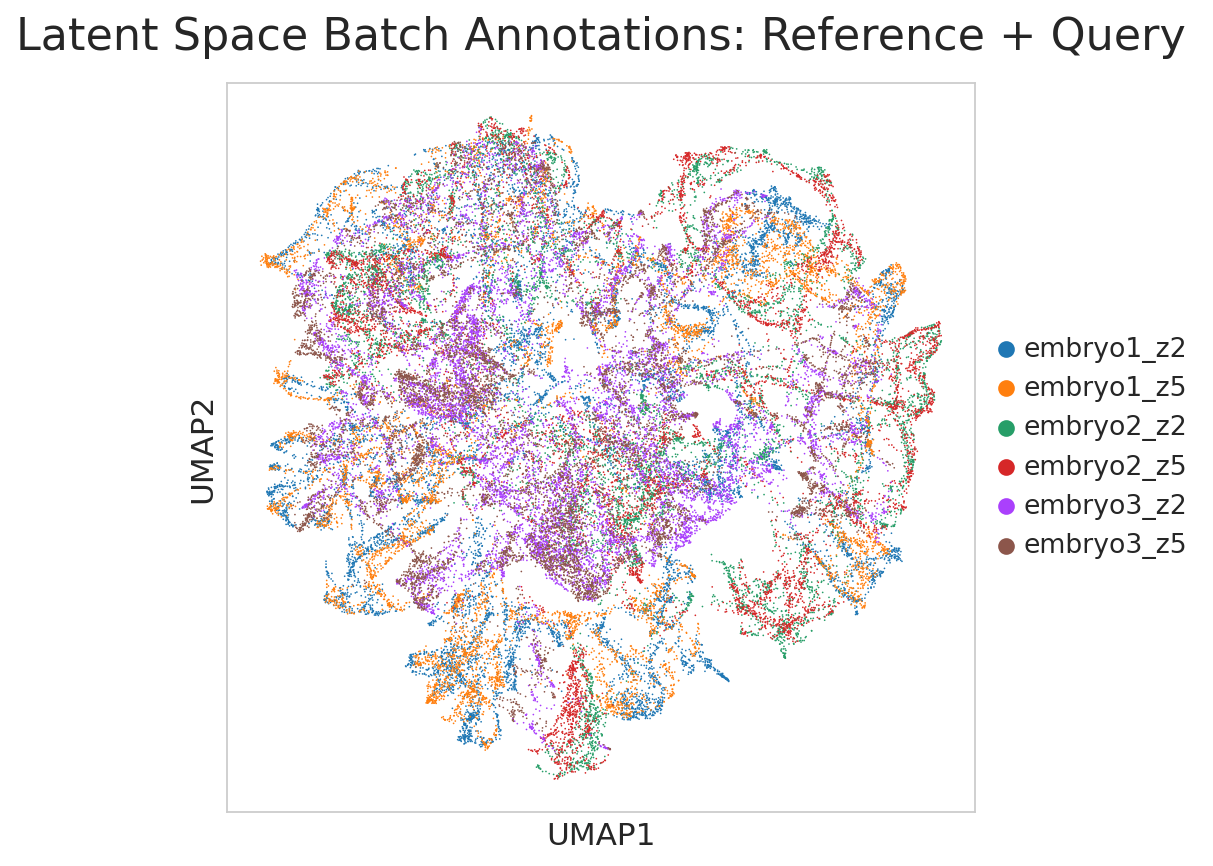

In [38]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(adata_reference_query,
                 color=[condition_key],
                 legend_fontsize=12,
                 return_fig=True)
plt.title("Latent Space Batch Annotations: Reference + Query", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_reference_query.png",
            bbox_inches="tight")

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


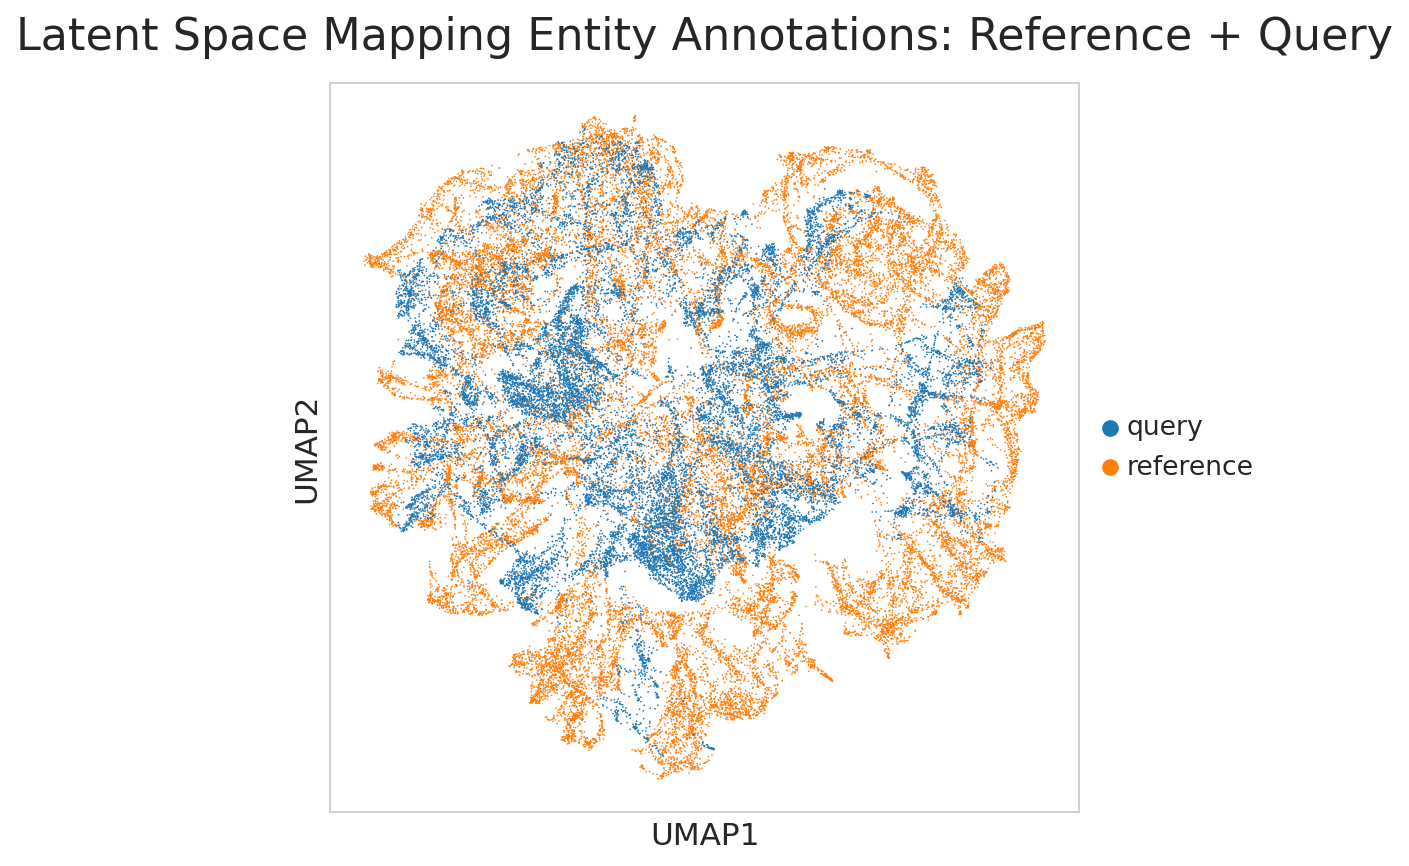

In [39]:
# Plot UMAP with mapping entity annotations
fig = sc.pl.umap(adata_reference_query,
                 color=["mapping_entity"],
                 legend_fontsize=12,
                 return_fig=True)
plt.title("Latent Space Mapping Entity Annotations: Reference + Query", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_mapping_entities_reference_query.png",
            bbox_inches="tight")

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


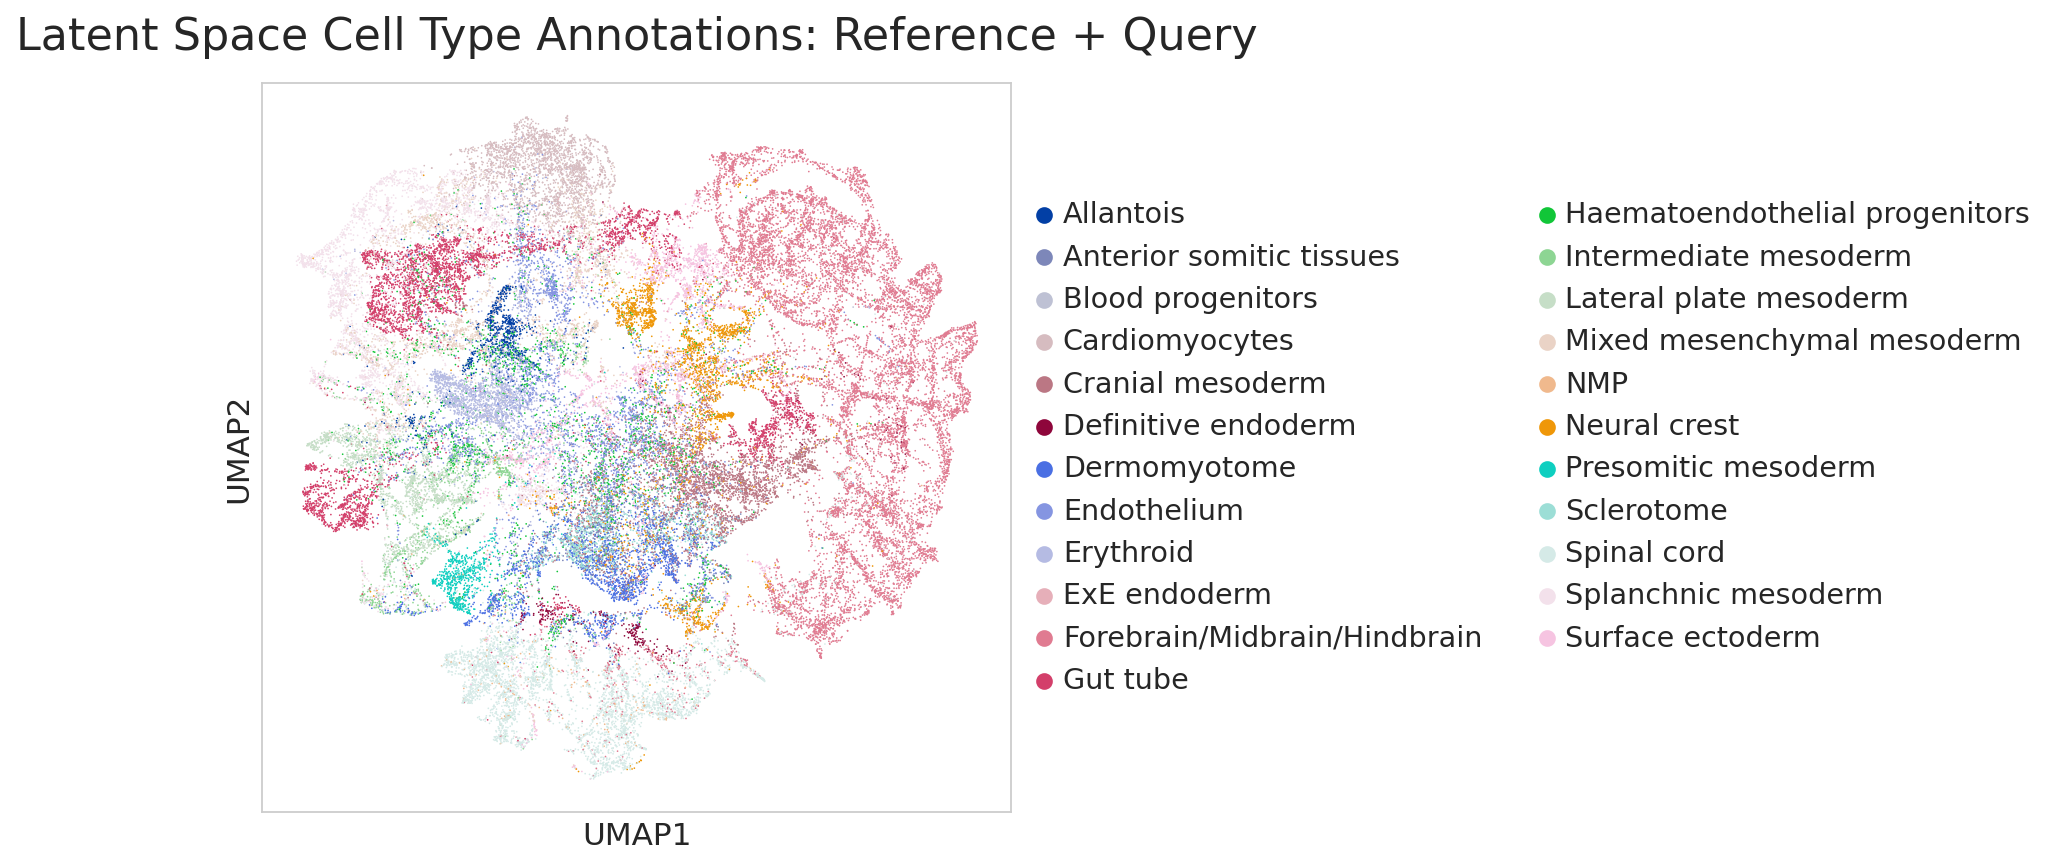

In [40]:
# Plot UMAP with recovered cell type annotations
fig = sc.pl.umap(adata_reference_query,
                 color=[cell_type_key],
                 return_fig=True)
plt.title("Latent Space Cell Type Annotations: Reference + Query", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_reference_query.png",
            bbox_inches="tight")

In [46]:
adata_reference_query.obs["recovered_cell_type"] = "Cell types present in reference"
adata_reference_query.obs.loc[adata_reference_query.obs[cell_type_key] == reference_removed_cell_type, "recovered_cell_type"] = reference_removed_cell_type

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


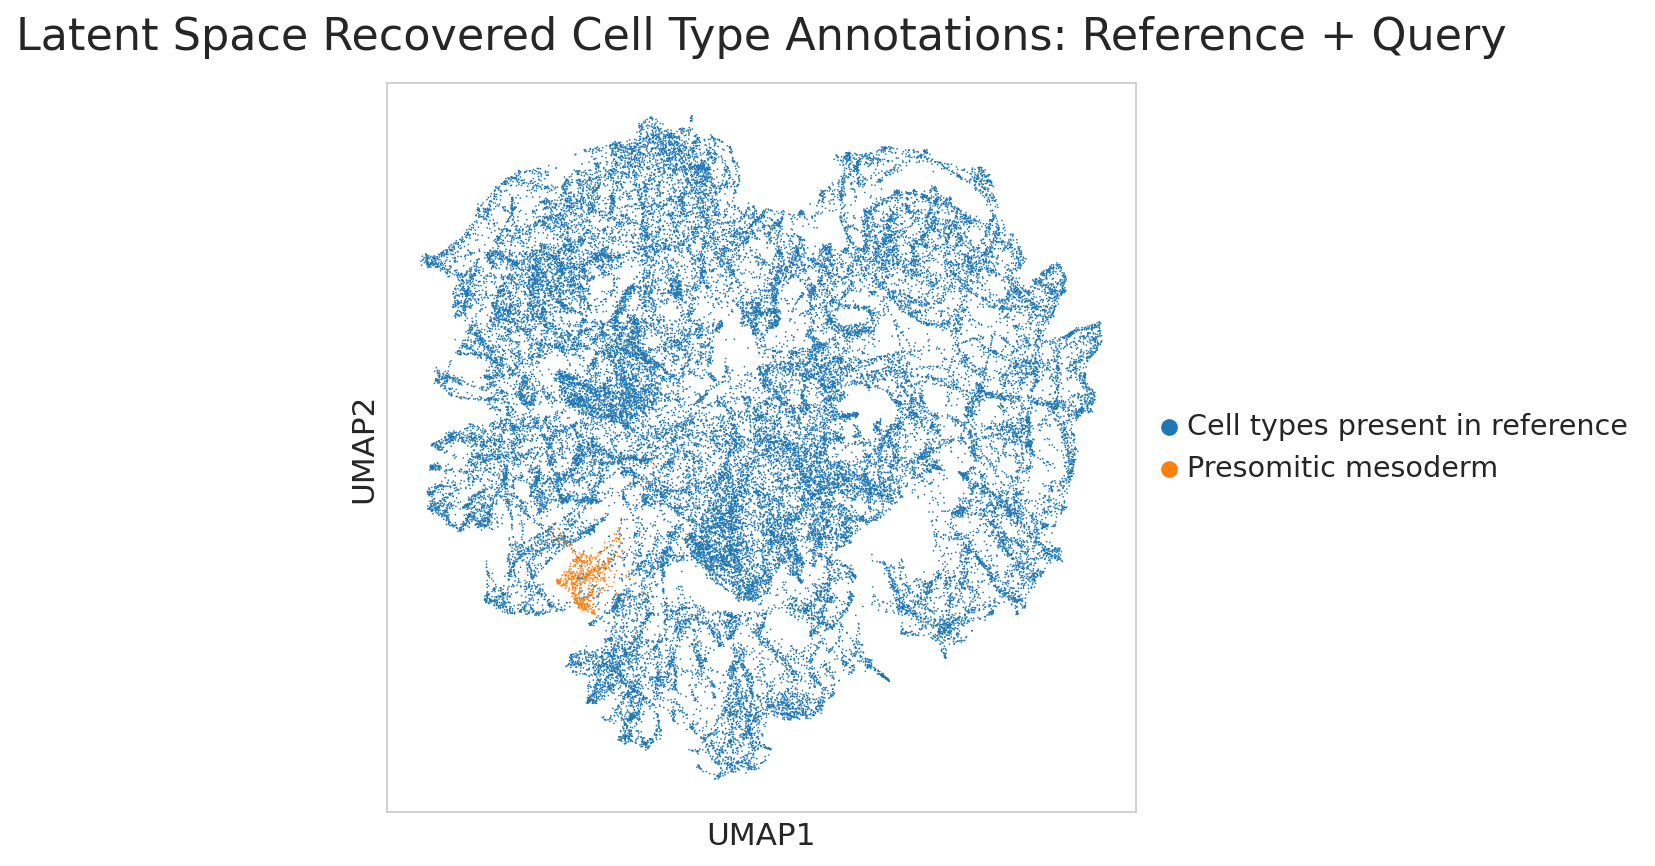

In [48]:
# Plot UMAP with reference removed cell type annotations
fig = sc.pl.umap(adata_reference_query,
                 color=["recovered_cell_type"],
                 return_fig=True)
plt.title("Latent Space Recovered Cell Type Annotations: Reference + Query", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_recovered_cell_types_reference_query.png",
            bbox_inches="tight")

##### 3.5.2.4 Analyze Metrics

In [49]:
metrics_dict_reference_query = {}

metrics_dict_reference_query["cad"] = compute_cad(
    adata=model.adata,
    cell_type_key=cell_type_key,
    spatial_knng_key=spatial_knng_key,
    latent_knng_key=latent_knng_key,
    spatial_key=spatial_key,
    latent_key=latent_key,
    n_neighbors=n_neighbors)

metrics_dict_reference_query["arclisi"] = compute_arclisi(
    adata=model.adata,
    cell_type_key=cell_type_key,
    spatial_key=spatial_key,
    latent_key=latent_key,
    n_neighbors=n_neighbors)
    
metrics_dict_reference_query["batch_asw"] = scib.me.silhouette_batch(
    model.adata,
    batch_key=condition_key,
    label_key=cell_type_key,
    embed=latent_key)

print(metrics_dict_reference_query)

# Store to disk
with open(f"{model_artifacts_folder_path}"
          "/reference_metrics.pickle", "wb") as f:
    pickle.dump(metrics_dict_reference_query, f)

mean silhouette per group:                                 silhouette_score
group                                           
Allantois                               0.870938
Anterior somitic tissues                0.943196
Blood progenitors                       0.937507
Cardiomyocytes                          0.973108
Cranial mesoderm                        0.924740
Definitive endoderm                     0.934824
Dermomyotome                            0.928086
Endothelium                             0.977345
Erythroid                               0.940969
ExE endoderm                            0.881904
Forebrain/Midbrain/Hindbrain            0.967865
Gut tube                                0.928338
Haematoendothelial progenitors          0.969469
Intermediate mesoderm                   0.919795
Lateral plate mesoderm                  0.925504
Mixed mesenchymal mesoderm              0.951983
NMP                                     0.954334
Neural crest                            0.

##### 3.5.2.5 Analyze Conditional Embedding

In [ ]:
# Get conditional embeddings
cond_embed = model.get_conditional_embeddings()
cond = adata_reference_query.obs["batch"].unique()

# Get top 2 principal components and plot them
pca = KernelPCA(n_components=2, kernel="linear")
cond_embed_pca = pca.fit_transform(cond_embed)
sns.scatterplot(x=cond_embed_pca[:, 0], 
                y=cond_embed_pca[:, 1], 
                hue=cond)
plt.title("Reference + Query Conditional Embeddings", pad=15)
plt.xlabel("Principal Component 1")
plt.xticks(fontsize=12)
plt.ylabel ("Principal Component 2")
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.02, 0.75),
           loc=2,
           borderaxespad=0.,
           fontsize=12,
           frameon=False)
plt.savefig(f"{figure_folder_path}/reference_query_cond_embed.png",
            bbox_inches="tight")